In [2]:
import sys
import requests
import json
from pathlib import Path

import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm


root = '../..' 
sys.path.append(root)
from src.tools import paths
from src.tools import data_tools as dt
from src.tools import scrape_tools as st

import networkx as nx
from pymongo import MongoClient
client = MongoClient("localhost", 27017)

# Mongo

In [3]:
db = client.musicind
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'musicind')

In [6]:
for res in db.songs.find({'artists':{'$elemMatch':{'name':'Greg'}}}):
    print(res)

{'_id': ObjectId('60370cf1a583a9d9100f7b15'), 'id': 'aaaaaaaa', 'title': 'Streets of Philadelphia', 'url': '/wiki/Streets_of_Philadelphia', 'artists': [{'name': 'Greg', 'url': '/wiki/Bruce_Springsteen', 'order': 0}], 'release_date': 'February 2, 1994', 'genres': ['Soft rock', ''], 'length': '3:15  (single edit)4:12 (soundtrack version)', 'songwriters': [], 'producers': [{'name': 'Bruce Springsteen', 'url': '/wiki/Bruce_Springsteen', 'order': 0}, {'name': 'Chuck Plotkin', 'url': '/wiki/Chuck_Plotkin', 'order': 1}]}


In [4]:
for res in db.songs.find({'artists':{'$elemMatch':{'name':'Taylor Swift'}}}):
    print(f"{res['title']} by {' and '.join(a['name'] for a in res['artists'])}")

Cardigan by Taylor Swift
You Need to Calm Down by Taylor Swift
You Belong with Me by Taylor Swift
Wildest Dreams by Taylor Swift
We Are Never Ever Getting Back Together by Taylor Swift
Style by Taylor Swift
Begin Again by Taylor Swift
Look What You Made Me Do by Taylor Swift
Shake It Off by Taylor Swift
Bad Blood by Taylor Swift and Kendrick Lamar
Back to December by Taylor Swift
Blank Space by Taylor Swift
I Don't Wanna Live Forever by Zayn and Taylor Swift
Me! by Taylor Swift and Brendon Urie and Panic! at the Disco
Exile by Taylor Swift and Bon Iver
Change by Taylor Swift
...Ready for It? by Taylor Swift
Red by Taylor Swift
Mine by Taylor Swift
Love Story by Taylor Swift
Fearless by Taylor Swift
Today Was a Fairytale by Taylor Swift
Lover by Taylor Swift
I Knew You Were Trouble by Taylor Swift


## People types and counts

In [4]:
people_types = ['artists','songwriters', 'producers']

In [5]:
people = {}
for ptype in people_types:
    people[ptype] = list(db.songs.aggregate(
[
    {
        '$unwind': {
            'path': f'${ptype}', 
            'includeArrayIndex': 'string', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$project': {
            'url': f'${ptype}.url', 
            'name': f'${ptype}.name'
        }
    }, {
        '$group': {
            '_id': '$url', 
            'name': {
                '$first': '$name'
            }
        }
    }
]))
{k:len(v) for k,v in people.items()}

{'artists': 2153, 'producers': 995, 'songwriters': 2418}

In [35]:
combined = pd.DataFrame( [{'cat':k, **song} for k,v in people.items() for song in v] )
combined

,cat,_id,name
0,artists,/wiki/The_Rascals,The Rascals
1,artists,/wiki/Johnny_Hates_Jazz,Johnny Hates Jazz
2,artists,/wiki/Pamela_Long_(singer),Pamela Long
3,artists,/wiki/Sam_Smith,Sam Smith
4,artists,/wiki/Soul_II_Soul,Soul II Soul
...,...,...,...
4007,producers,/wiki/Harvey_Fuqua,Harvey Fuqua
4008,producers,/wiki/Dave_Bassett_(songwriter),Dave Bassett
4009,producers,/wiki/Ashford_%26_Simpson,Ashford & Simpson
4010,producers,/wiki/Tom_Allom,Tom Allom


# Prolific

In [6]:
prolific = {}
for ptype in people_types:
    prolific[ptype] = list(db.songs.aggregate([
    {
        '$unwind': {
            'path': f'${ptype}', 
            'includeArrayIndex': 'string', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$project': {
            f'{ptype}_url': f'${ptype}.url', 
            f'{ptype}_name': f'${ptype}.name', 
            'song_name': '$title', 
            'song_url': '$url'
        }
    }, {
        '$group': {
            '_id': f'${ptype}_name', 
            'count': {
                '$sum': 1
            }, 
            'name': {
                '$first': f'${ptype}_url'
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]))


In [8]:
cols = ['wikipedia_url', 'count', 'name']

In [9]:
df = pd.DataFrame(prolific['producers'][:30])
df.columns=cols
df

,wikipedia_url,count,name
0,Max Martin,61,/wiki/Max_Martin
1,Dr. Luke,37,/wiki/Dr._Luke
2,Madonna,28,/wiki/Madonna
3,Benny Blanco,28,/wiki/Benny_Blanco
4,Shellback,24,/wiki/Shellback_(record_producer)
5,Babyface,22,/wiki/Babyface_(musician)
6,Jimmy Jam and Terry Lewis,22,/wiki/Jimmy_Jam_and_Terry_Lewis
7,Timbaland,21,/wiki/Timbaland
8,L.A. Reid,19,/wiki/L.A._Reid
9,Hugh Padgham,18,/wiki/Hugh_Padgham


In [10]:
df = pd.DataFrame(prolific['artists'][:30])
df.columns=cols
df

,wikipedia_url,count,name
0,Drake,37,/wiki/Drake_(musician)
1,Madonna,37,/wiki/Madonna
2,the Beatles,33,/wiki/The_Beatles
3,Rihanna,31,/wiki/Rihanna
4,Michael Jackson,28,/wiki/Michael_Jackson
5,Janet Jackson,27,/wiki/Janet_Jackson
6,Stevie Wonder,26,/wiki/Stevie_Wonder
7,Mariah Carey,24,/wiki/Mariah_Carey
8,Taylor Swift,24,/wiki/Taylor_Swift
9,Elvis Presley,23,/wiki/Elvis_Presley


In [11]:
df = pd.DataFrame(prolific['songwriters'][:30])
df.columns=cols
df

,wikipedia_url,count,name
0,Max Martin,73,/wiki/Max_Martin
1,Aubrey Graham,40,/wiki/Drake_(musician)
2,Lukasz Gottwald,36,/wiki/Dr._Luke
3,Madonna,30,/wiki/Madonna
4,Mariah Carey,24,/wiki/Mariah_Carey
5,Terry Lewis,23,None
6,Benjamin Levin,23,/wiki/Benny_Blanco
7,Beyoncé Knowles,22,/wiki/Beyonc%C3%A9
8,Kanye West,22,/wiki/Kanye_West
9,James Harris III,22,None


# Networks

# Artist-Songwriter

In [3]:
import networkx

In [4]:
tree = list(db.songs.aggregate([
    {
        '$unwind': {
            'path': '$songwriters', 
            'includeArrayIndex': 'string', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$unwind': {
            'path': '$artists', 
            'includeArrayIndex': 'string', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$project': {
            'songwriter_url': '$songwriters.url', 
            'songwriter_name': '$songwriters.name', 
            'artist_url': '$artists.url', 
            'artist_name': '$artists.name', 
            'song_name': '$title', 
            'song_url': '$url', 
            'edge': {
                '$concat': [
                    '$songwriters.name', ';;', '$artists.name'
                ]
            }
        }
    }, {
        '$group': {
            '_id': '$edge', 
            'count': {
                '$sum': 1
            }, 
            'songwriter_name': {
                '$first': '$songwriter_name'
            }, 
            'artist_name': {
                '$first': '$artist_name'
            }, 
#             'song': {
#                 '$first': '$song_name'
#             }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]))
len(tree)

7375

In [101]:
[d['songwriter_name'] for d in tree[:5]]

['Aubrey Graham',
 'Madonna',
 'Mariah Carey',
 'Justin Timberlake',
 'Shawn Carter']

In [16]:
pd.DataFrame(tree[:20])

,_id,count,songwriter_name,artist_name,song
0,Aubrey Graham;;Drake,35,Aubrey Graham,Drake,Toosie Slide
1,Madonna;;Madonna,30,Madonna,Madonna,True Blue
2,Mariah Carey;;Mariah Carey,23,Mariah Carey,Mariah Carey,Fantasy
3,Justin Timberlake;;Justin Timberlake,18,Justin Timberlake,Justin Timberlake,Give It to Me
4,Shawn Carter;;Jay-Z,18,Shawn Carter,Jay-Z,Heartbreaker
5,Janet Jackson;;Janet Jackson,18,Janet Jackson,Janet Jackson,If
6,Marshall Mathers;;Eminem,18,Marshall Mathers,Eminem,Shake That
7,Kanye West;;Kanye West,18,Kanye West,Kanye West,Gold Digger
8,Justin Bieber;;Justin Bieber,17,Justin Bieber,Justin Bieber,I Don't Care
9,Taylor Swift;;Taylor Swift,17,Taylor Swift,Taylor Swift,Cardigan


In [108]:
g = nx.Graph()
# for entry in tree[-100:]:
#     if entry['songwriter_name']==entry['artist_name']:
#         continue
# #     g.add_node(entry['artist_url'], label=entry['artist_name'], category='artist')
# #     g.add_node(entry['producer_url'], label=entry['producer_name'], category='producer')
#     g.add_edge(entry['songwriter_name'],entry['artist_name'])
g.add_nodes_from([d['songwriter_name'] for d in tree], role='songwriter')
g.add_nodes_from([d['artist_name'] for d in tree], role='artist')
edges = ((e['songwriter_name'],e['artist_name'], e['count']) for e in tree if e['songwriter_name']!=e['artist_name'])
g.add_weighted_edges_from(edges)

In [16]:
g.neighbors(list(g.nodes())[0])


In [109]:
g.nodes(data=True)

NodeDataView({'Aubrey Graham': {'role': 'songwriter'}, 'Madonna': {'role': 'artist'}, 'Mariah Carey': {'role': 'artist'}, 'Justin Timberlake': {'role': 'artist'}, 'Shawn Carter': {'role': 'songwriter'}, 'Janet Jackson': {'role': 'artist'}, 'Marshall Mathers': {'role': 'songwriter'}, 'Kanye West': {'role': 'artist'}, 'Justin Bieber': {'role': 'artist'}, 'Taylor Swift': {'role': 'artist'}, 'Terry Lewis': {'role': 'songwriter'}, 'Philip Lawrence': {'role': 'songwriter'}, 'Adam Levine': {'role': 'artist'}, 'Katy Perry': {'role': 'artist'}, 'Onika Maraj': {'role': 'songwriter'}, 'Bruno Mars': {'role': 'artist'}, 'James Harris III': {'role': 'songwriter'}, 'Beyoncé Knowles': {'role': 'artist'}, 'Max Martin': {'role': 'songwriter'}, 'Noah Shebib': {'role': 'songwriter'}, 'Stefani Germanotta': {'role': 'songwriter'}, 'Lukasz Gottwald': {'role': 'songwriter'}, 'Ariana Grande': {'role': 'artist'}, 'Shaffer Smith': {'role': 'songwriter'}, 'Abel Tesfaye': {'role': 'songwriter'}, 'Ari Levine': {'ro

In [56]:
import matplotlib.pyplot as plt

In [120]:
from collections import Counter
Counter(nx.get_node_attributes(H,'role').values())

Counter({'artist': 32, 'songwriter': 1})

In [82]:
H.get_edge_data('Max Martin', 'Katy Perry')

{'weight': 13}

dict_values([1, 3, 1, 2, 1, 1, 1, 1, 7, 1, 11, 3, 1, 1, 1, 6, 2, 3, 1, 2, 1, 1, 4, 2, 1, 2, 1, 8, 3, 2, 1, 3, 3])

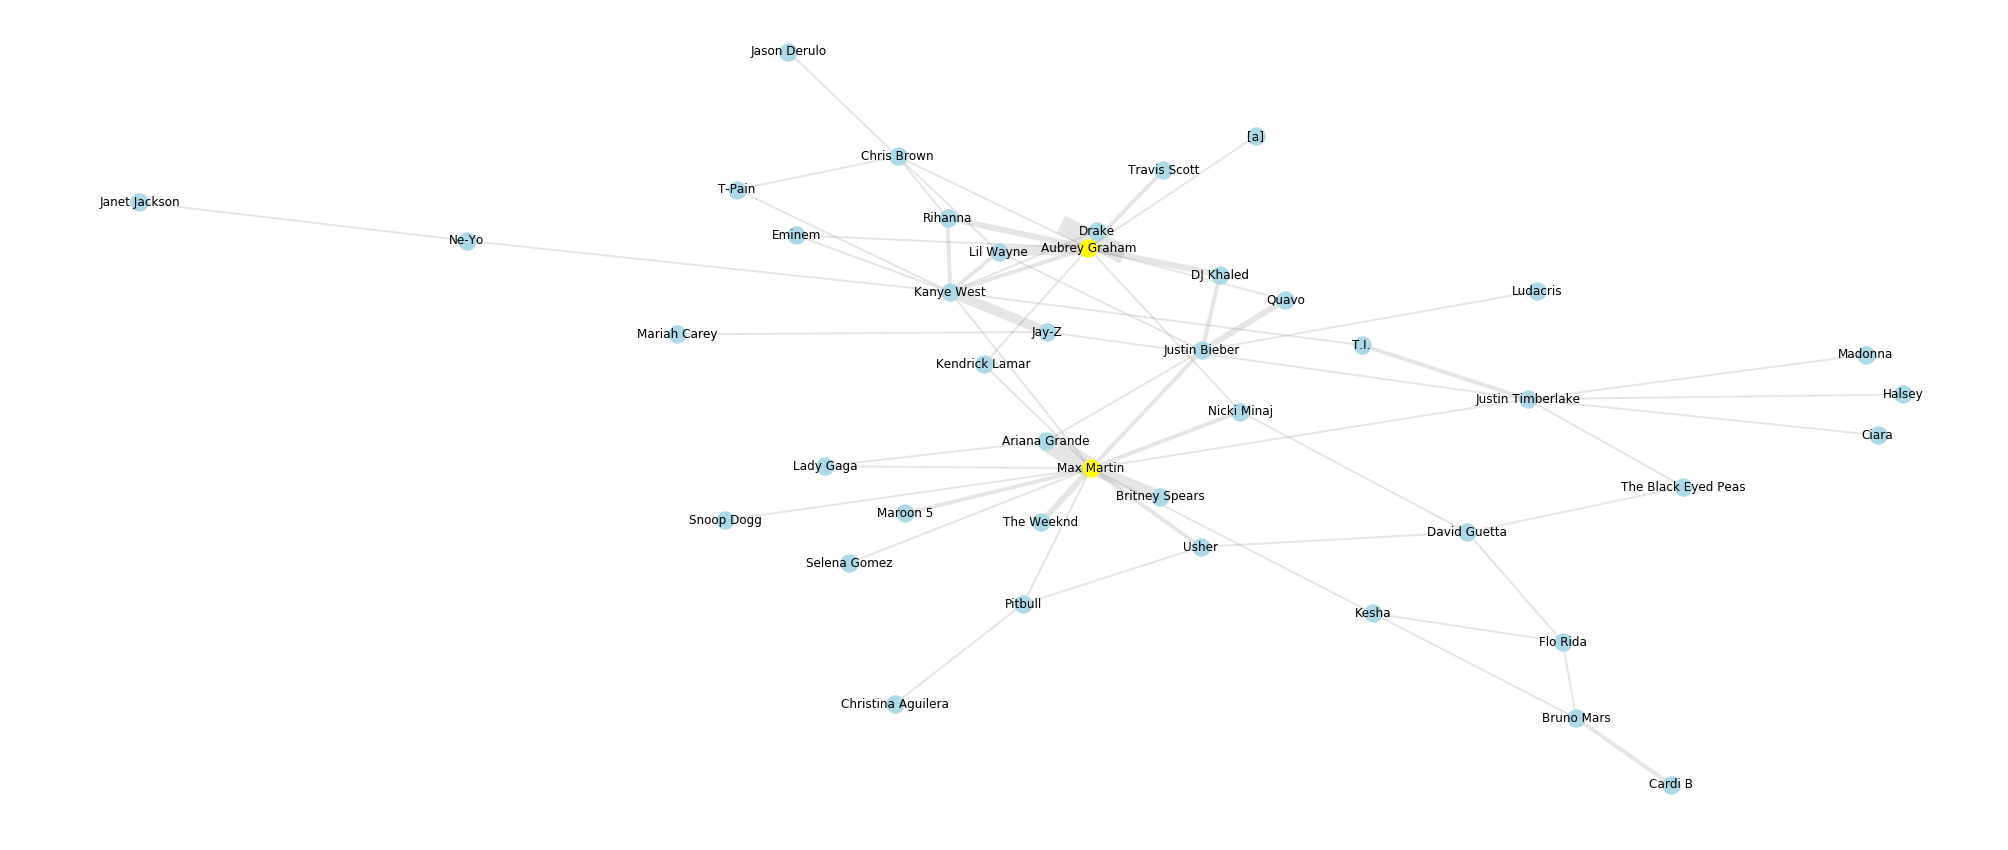

In [131]:
subset = [ n for n,d in dict(g.degree()).items() if d>=25]
H = g.subgraph(subset).copy()
H.remove_nodes_from(list(nx.isolates(H)))
                    
pos = nx.spring_layout(H, iterations=100,)
artists = [n for n,r in nx.get_node_attributes(H,'role').items() if r=='artist']
songwriters = [n for n,r in nx.get_node_attributes(H,'role').items() if r=='songwriter']

fig, ax = plt.subplots()
fig.set_size_inches(35,15)
nx.draw_networkx_nodes(H, pos, nodelist=artists, node_color='lightblue', )
nx.draw_networkx_nodes(H, pos, nodelist=songwriters, node_color='yellow')
nx.draw_networkx_labels(H,pos)
edgewidth = [ 2*d['weight'] for (u,v,d) in H.edges(data=True)]
nodesize = []
nx.draw_networkx_edges(H, pos,  edge_color="grey", alpha=0.2, width=edgewidth)
# nx.draw(H, with_labels=True, font_weight='bold',)

plt.axis('off')
plt.show()

# Artist-Producer

In [3]:
import networkx

In [132]:
tree = list(db.songs.aggregate([
    {
        '$unwind': {
            'path': '$producers', 
            'includeArrayIndex': 'string', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$unwind': {
            'path': '$artists', 
            'includeArrayIndex': 'string', 
            'preserveNullAndEmptyArrays': False
        }
    }, {
        '$project': {
            'producer_url': '$producers.url', 
            'producer_name': '$producers.name', 
            'artist_url': '$artists.url', 
            'artist_name': '$artists.name', 
            'song_name': '$title', 
            'song_url': '$url', 
            'edge': {
                '$concat': [
                    '$producers.name', ';;', '$artists.name'
                ]
            }
        }
    }, {
        '$group': {
            '_id': '$edge', 
            'count': {
                '$sum': 1
            }, 
            'producer_name': {
                '$first': '$producer_name'
            }, 
            'artist_name': {
                '$first': '$artist_name'
            }, 
#             'song': {
#                 '$first': '$song_name'
#             }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]))
len(tree)

2567

In [133]:
pd.DataFrame(tree[:20])

,_id,count,producer_name,artist_name
0,Madonna;;Madonna,28,Madonna,Madonna
1,Jimmy Jam and Terry Lewis;;Janet Jackson,19,Jimmy Jam and Terry Lewis,Janet Jackson
2,Mariah Carey;;Mariah Carey,16,Mariah Carey,Mariah Carey
3,Janet Jackson;;Janet Jackson,15,Janet Jackson,Janet Jackson
4,Timbaland;;Justin Timberlake,14,Timbaland,Justin Timberlake
5,Taylor Swift;;Taylor Swift,13,Taylor Swift,Taylor Swift
6,Dr. Luke;;Katy Perry,12,Dr. Luke,Katy Perry
7,Justin Timberlake;;Justin Timberlake,12,Justin Timberlake,Justin Timberlake
8,Lady Gaga;;Lady Gaga,11,Lady Gaga,Lady Gaga
9,Bruce Springsteen;;Bruce Springsteen,11,Bruce Springsteen,Bruce Springsteen


In [134]:
g = nx.Graph()
# for entry in tree[-100:]:
#     if entry['songwriter_name']==entry['artist_name']:
#         continue
# #     g.add_node(entry['artist_url'], label=entry['artist_name'], category='artist')
# #     g.add_node(entry['producer_url'], label=entry['producer_name'], category='producer')
#     g.add_edge(entry['songwriter_name'],entry['artist_name'])
g.add_nodes_from([d['producer_name'] for d in tree], role='producer')
g.add_nodes_from([d['artist_name'] for d in tree], role='artist')
edges = ((e['producer_name'],e['artist_name'], e['count']) for e in tree if e['producer_name']!=e['artist_name'])
g.add_weighted_edges_from(edges)

In [140]:
sorted(dict(g.degree).values(),reverse=True)[:30]

[48,
 46,
 31,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 25,
 22,
 22,
 22,
 21,
 20,
 20,
 19,
 19,
 19,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 15,
 15,
 14]

In [145]:
[n for n.atH.degree

DegreeView({'Zedd': 4, 'Miley Cyrus': 2, 'Timbaland': 8, 'Babyface': 1, 'Shawn Mendes': 2, 'Ariana Grande': 3, 'Shellback': 11, 'Puff Daddy': 2, 'Eminem': 2, 'Madonna': 5, 'David Guetta': 5, 'Ed Sheeran': 3, 'Katy Perry': 5, 'Cubeatz': 5, 'Kendrick Lamar': 3, 'Snoop Dogg': 3, 'Justin Timberlake': 8, 'Missy Elliott': 2, 'Post Malone': 2, 'Giorgio Tuinfort': 5, 'Maroon 5': 4, 'Michael Jackson': 6, 'Danja': 7, 'R. Kelly': 1, 'Andrew Watt': 7, 'Max Martin': 17, 'Benny Blanco': 15, 'Ne-Yo': 6, 'Quavo': 2, 'Cirkut': 9, 'Cardi B': 3, 'Nicki Minaj': 6, 'Stargate': 6, 'Paul McCartney': 1, 'Khalid': 2, 'Justin Bieber': 9, 'Lady Gaga': 2, 'Selena Gomez': 4, 'Jay-Z': 5, 'The-Dream': 5, 'Louis Bell': 4, 'Christina Aguilera': 2, 'Halsey': 2, 'DJ Frank E': 1, 'Chris Brown': 2, 'The Weeknd': 2, 'Usher': 4, 'Travis Scott': 3, 'Drake': 3, 'Juice Wrld': 2, 'Rihanna': 7, 'DJ Khaled': 5, 'Kanye West': 4, 'Pitbull': 4, '50 Cent': 2, 'Flo Rida': 4, 'Mariah Carey': 3, 'Beyoncé': 5, 'Britney Spears': 5, "Desti

In [148]:
nx.get_node_attributes(artists, 'role')

AttributeError: 'list' object has no attribute 'nodes'

In [167]:
nx.get_edge_attributes(H,'weight').values()

dict_values([1, 1, 1, 1, 1, 1, 1, 5, 3, 2, 1, 1, 1, 1, 1, 1, 1, 7, 1, 8, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 12, 10, 5, 4, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 8, 1, 1, 1, 1, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 7, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 4, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 1])

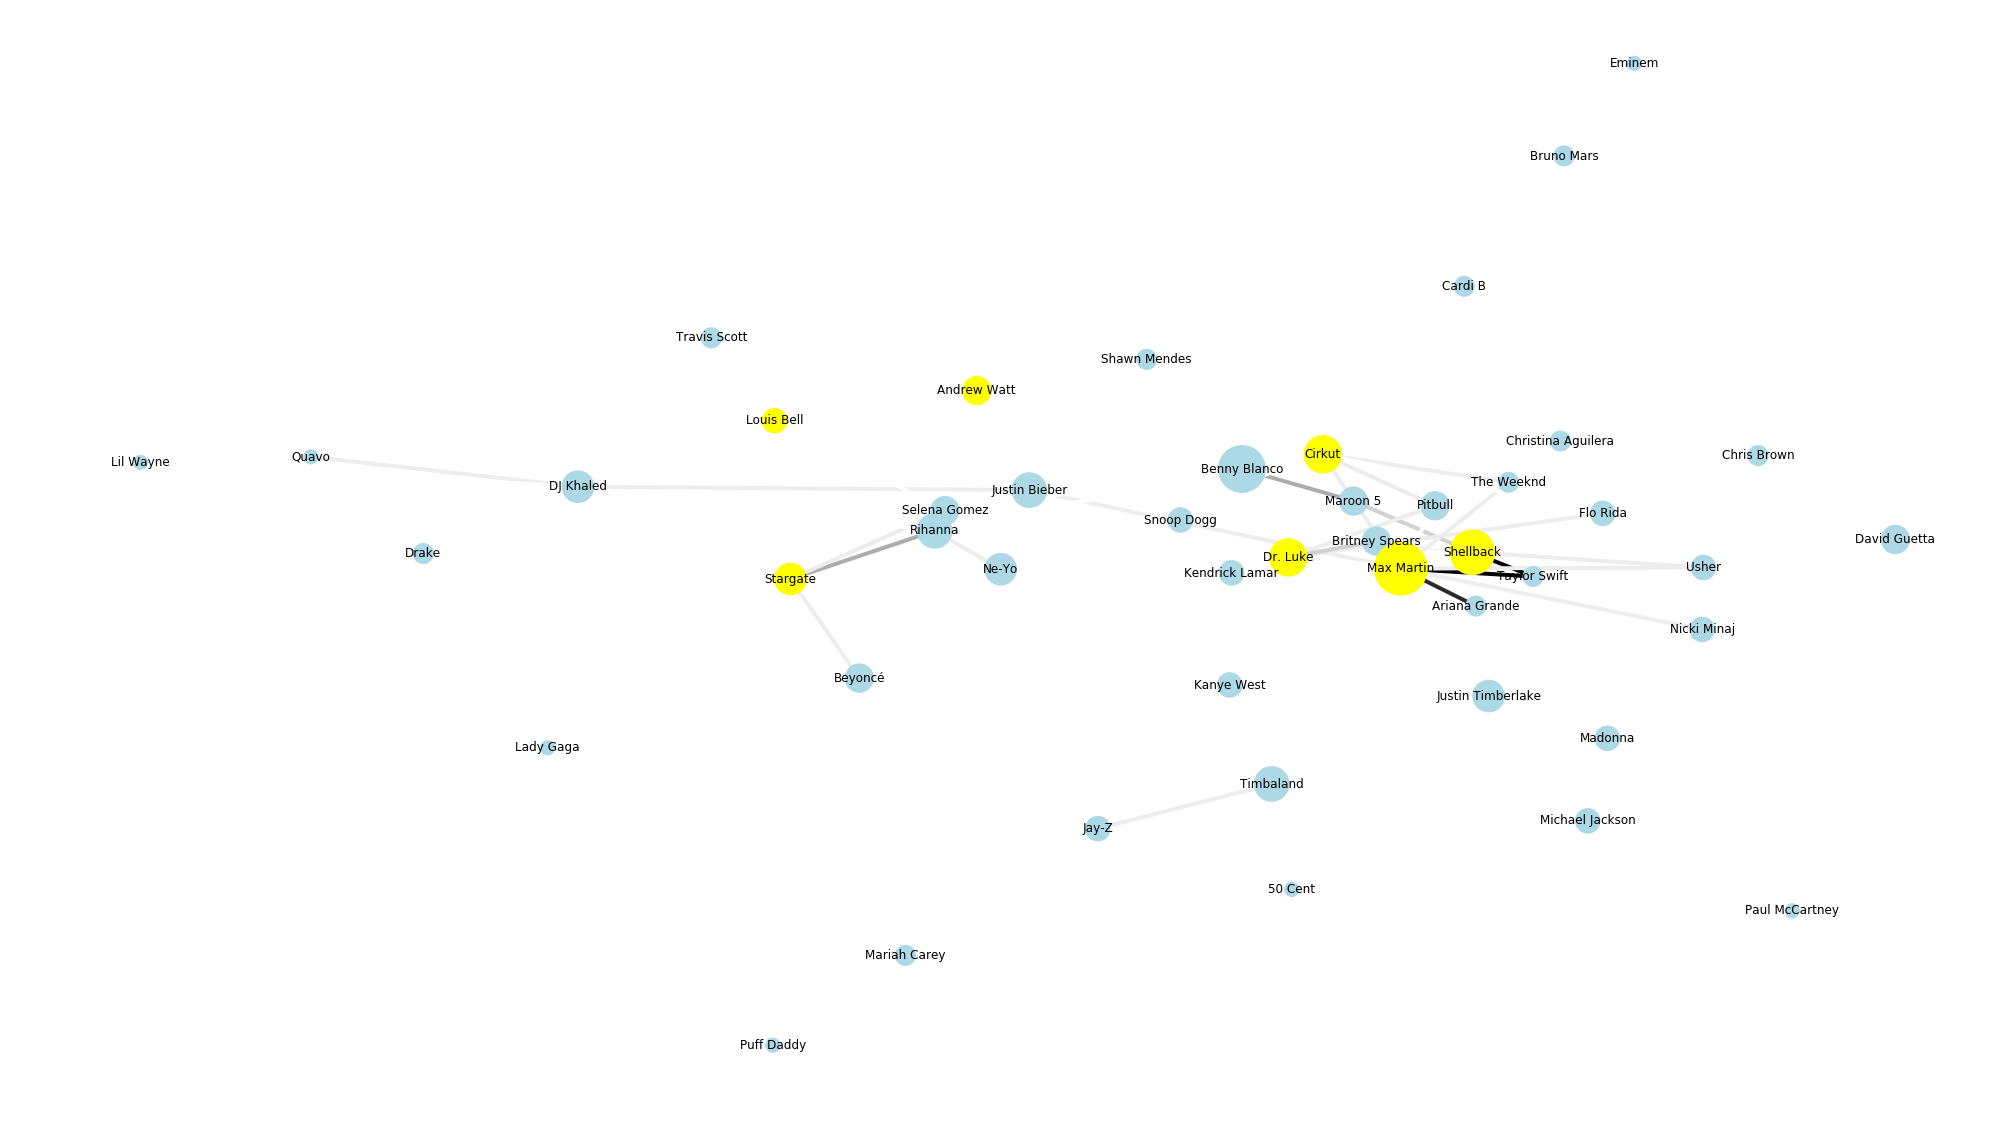

In [178]:
subset = [ n for n,d in dict(g.degree()).items() if d>=11]
H = g.subgraph(subset).copy()
H.remove_nodes_from(list(nx.isolates(H)))
                    
pos = nx.spring_layout(H, iterations=100,)
artists = [n for n,r in nx.get_node_attributes(H,'role').items() if r=='artist']
producers = [n for n,r in nx.get_node_attributes(H,'role').items() if r=='producer']

fig, ax = plt.subplots()
fig.set_size_inches(35,20)
nx.draw_networkx_nodes(H, pos, nodelist=artists, node_color='lightblue', 
                       node_size=[200*d for n,d in dict(H.degree()).items() if n in artists])
nx.draw_networkx_nodes(H, pos, nodelist=producers, node_color='yellow',
                      node_size=[200*d for n,d in dict(H.degree()).items() if n in producers])
# nx.draw_networkx_edge_labels(H, pos, )
nx.draw_networkx_labels(H,pos,)

edgewidth = [ 2*d['weight'] for (u,v,d) in H.edges(data=True)]
nx.draw_networkx_edges(H, pos, width=4, edge_color=list(nx.get_edge_attributes(H,'weight').values()), edge_cmap=plt.cm.Greys)

plt.axis('off')
plt.show()

In [180]:
list(g.neighbors('Max Martin'))

['Katy Perry',
 'Taylor Swift',
 'Britney Spears',
 'Ariana Grande',
 'Pink',
 'Backstreet Boys',
 'Justin Bieber',
 'Usher',
 'Kelly Clarkson',
 'Nicki Minaj',
 'Maroon 5',
 'Robyn',
 'The Weeknd',
 'Nicki\xa0Minaj',
 'Justin Timberlake',
 'Kesha',
 'Snoop Dogg',
 'Selena Gomez',
 'Celine Dion',
 'Adam Lambert',
 'Kanye West',
 'Ellie Goulding',
 'Zedd',
 'Glee Cast',
 'Pitbull',
 'Jessie J',
 'Juicy J',
 'Adele',
 'Ed Sheeran',
 'Kendrick Lamar',
 'Skip Marley']

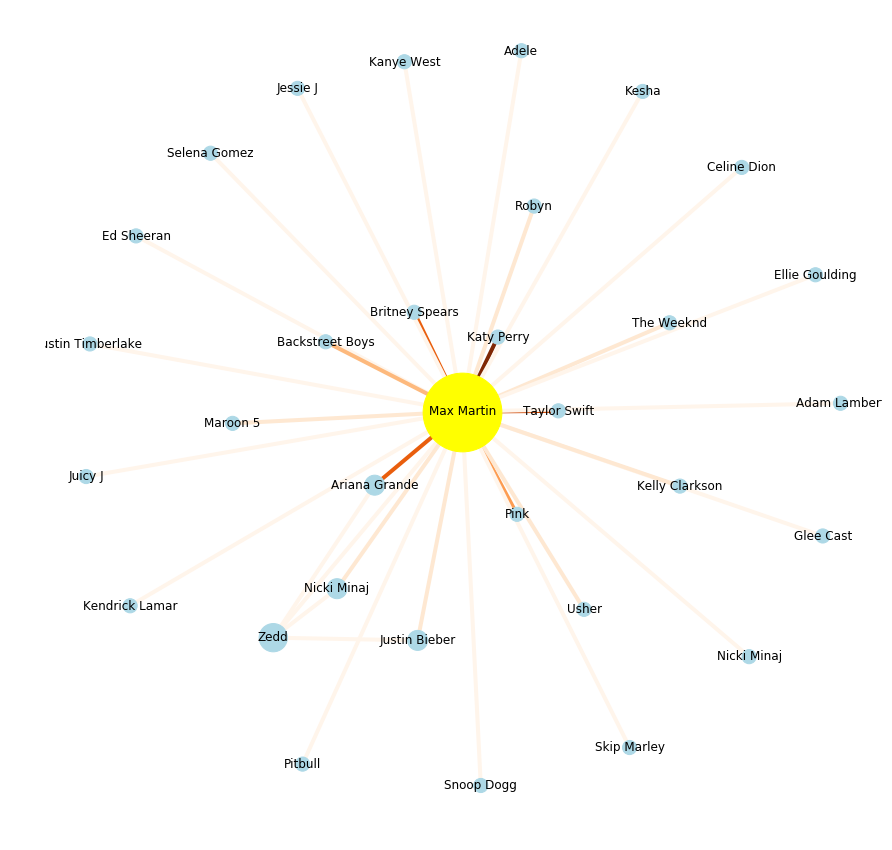

In [185]:

H = g.subgraph(['Max Martin', *list(g.neighbors('Max Martin'))]).copy()
H.remove_nodes_from(list(nx.isolates(H)))
                    
pos = nx.spring_layout(H, iterations=100,)
artists = [n for n,r in nx.get_node_attributes(H,'role').items() if r=='artist']
producers = [n for n,r in nx.get_node_attributes(H,'role').items() if r=='producer']

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
nx.draw_networkx_nodes(H, pos, nodelist=artists, node_color='lightblue', 
                       node_size=[200*d for n,d in dict(H.degree()).items() if n in artists])
nx.draw_networkx_nodes(H, pos, nodelist=producers, node_color='yellow',
                      node_size=[200*d for n,d in dict(H.degree()).items() if n in producers])
# nx.draw_networkx_edge_labels(H, pos, )
nx.draw_networkx_labels(H,pos,)

edgewidth = [ 2*d['weight'] for (u,v,d) in H.edges(data=True)]
nx.draw_networkx_edges(H, pos, width=4, edge_color=list(2*x for x in nx.get_edge_attributes(H,'weight').values()), edge_cmap=plt.cm.Oranges)

plt.axis('off')
plt.show()